In [1]:
%load_ext rpy2.ipython

/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# R package names
# packnames = ('ggplot2', 'dplyr', 'tidyr', 'lme4', 'data.table', 'lmerTest', 'effects', 'pander', 'psych', 'Hmisc', 'ggpubr', 'ggrepel')
packnames = ('ggplot2', 'dplyr', 'tidyr', 'ggpubr')

# R vector of strings
from rpy2.robjects.vectors import StrVector

utils.install_packages(StrVector(packnames))


/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cloud.r-project.org/src/contrib/ggplot2_3.2.1.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3204655 bytes (3.1 MB)

  warnings.warn(x, RRuntimeWarning)
/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 3.1 MB


  warni

rpy2.rinterface.NULL

In [3]:
dplyr = rpackages.importr("dplyr")
tidyr = rpackages.importr("tidyr")
ggplot2 = rpackages.importr("ggplot2")
ggpubr = rpackages.importr("ggpubr")
# lme4 = rpackages.importr("lme4")  
# data.table = rpackages.importr("data.table")
# lmerTest = rpackages.importr("lmerTest")
# effects = rpackages.importr("effects")
# pander = rpackages.importr("pander")
# psych = rpackages.importr("psych")
# Hmisc = rpackages.importr("Hmisc")
# ggpubr = rpackages.importr("ggpubr")
# ggrepel = rpackages.importr("ggrepel")

In [12]:
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

string = """
is_outlier <- function(x) {
  return(x < quantile(x, 0.25) - 1.5 * IQR(x) | x > quantile(x, 0.75) + 1.5 * IQR(x))
}
"""

is_outlier = SignatureTranslatedAnonymousPackage(string, "is_outlier")

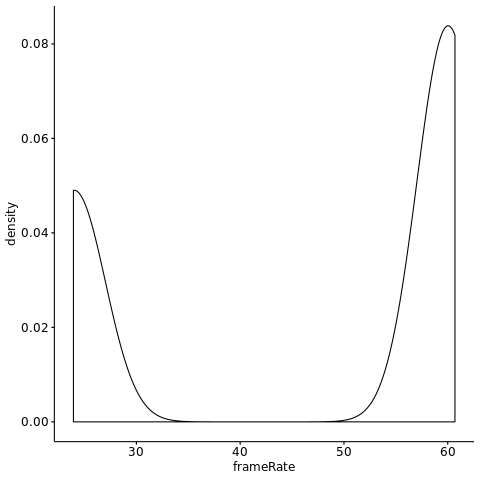

In [60]:
%%R
MID_long <- read.csv("/corral-secure/utdmc/Dell-Medical-Imaging/ULG/BIDS/derivatives/repo/fMRI-tasks/MID/data/MID_merged_bdat.csv")
MID_long$probeResp.corr <- as.integer(MID_long$probeResp.corr)
MID_long$run <- as.factor(MID_long$run)

# replace NA with 0s
MID_long$probeResp.corr[is.na(MID_long$probeResp.corr)] <- 0
MID_long$probeResp.rt[is.na(MID_long$probeResp.rt)] <- 0

MID_wide <- MID_long %>% 
  filter(Condition != "") %>%
  group_by(participant, Condition, run) %>%
  summarise(meanacc = mean(probeResp.corr), meanrt =1000* mean(probeResp.rt, na.rm=TRUE), frameRate = mean(frameRate))

# recategorize conditions
MID_wide <- MID_wide %>% mutate(cond = case_when(
        Condition == "LgPun" | Condition == "SmallPun" ~ "Loss",
        Condition == "LgReward" | Condition == "SmallReward" ~ "Reward", 
        Condition == "Triangle" ~ "Neutral")) 

MID_wide <- MID_wide %>% mutate(frameRate = case_when(
        frameRate < 40 ~  24,
        frameRate > 50 ~ 60))

MID_wide$frameRate <- as.factor(MID_wide$frameRate)

ggdensity(MID_long, x = "frameRate")



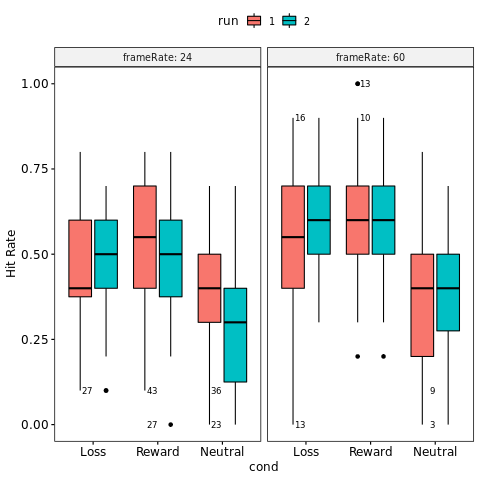

In [13]:
%%R

ggboxplot(MID_wide, "cond", "meanacc", fill = "run", ylab = "Hit Rate", facet.by = "frameRate", short.panel.labs = FALSE) + 
  geom_text(aes(label=ifelse((meanacc < quantile(meanacc, 0.25) - 1.5 * IQR(meanacc) | meanacc > quantile(meanacc, 0.75) + 1.5 * IQR(meanacc)),paste(participant),"")), hjust=1.1, check_overlap = TRUE, size=3, position = position_dodge(1))


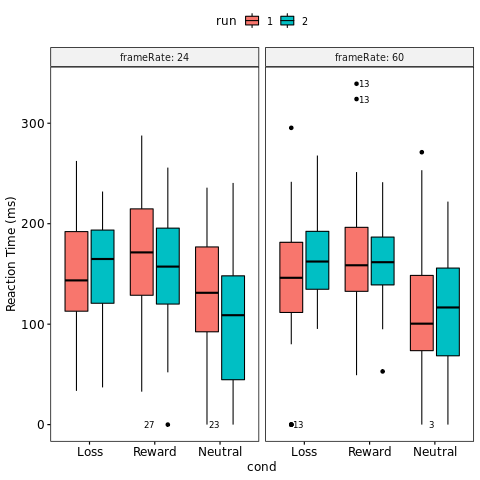

In [15]:
%%R
# meanrt is for correct trials only
ggboxplot(MID_wide, "cond", "meanrt", fill = "run", ylab = "Reaction Time (ms)", facet.by = "frameRate", short.panel.labs = FALSE) + 
  geom_text(aes(label=ifelse((meanrt < quantile(meanrt, 0.25) - 1.5 * IQR(meanrt) | meanrt > quantile(meanrt, 0.75) + 1.5 * IQR(meanrt)),paste(participant),"")), hjust=1.1, check_overlap = TRUE, size=3, position = position_dodge(1))

# SST

In [77]:
%%R
SST_long <- read.csv("/corral-secure/utdmc/Dell-Medical-Imaging/ULG/BIDS/derivatives/repo/fMRI-tasks/SST/data/SST_merged_bdat.csv")
SST_long$frameRate <- as.character(SST_long$frameRate)
SST_long$run <- as.factor(SST_long$run)

# manually change 038's framerate
SST_long$frameRate[SST_long$participant == 38 & SST_long$run == 1] <- 24

SST_long <- SST_long %>% mutate(frameRate = case_when(
        frameRate < 26 ~  24,
        frameRate > 58 ~ 60))

SST_long$frameRate <- as.factor(SST_long$frameRate)

# calculate corr go RT
SST_corr_go_rt <- SST_long %>%
  filter(trial_type == "go" & key_response.corr == 1) %>%
  group_by(participant, run) %>%
  summarise(go_correct_rt = 1000*mean(key_response.rt)) %>% ungroup()

# calc stop err RT
SST_stop_err_rt <- SST_long %>%
  filter(trial_type == "stop" & key_response.corr == 0) %>%
  group_by(participant, run) %>%
  summarise(stop_error_rt = 1000*mean(key_response.rt)) %>% ungroup() 

SST_wide <- SST_long %>% 
  filter(trial_type != "") %>%
  group_by(participant, trial_type, run, frameRate) %>%
  summarise(meanacc = mean(key_response.corr, na.rm = TRUE), meanrt = 1000* mean(key_response.rt, na.rm=TRUE), ssd = 1000*mean(ss_delay), stopError = sum(trial_type == "stop" & key_response.corr == 0), stopTotal = sum(trial_type == "stop"), GoCorr = sum(trial_type == "go" & key_response.corr == 1), GoTotal = sum(trial_type == "go")) %>% ungroup() 
            

SST_wide <- merge(SST_wide, SST_corr_go_rt, by = c('participant', 'run'))

SST_wide <- merge(SST_wide, SST_stop_err_rt, by = c('participant', 'run'))



SST_wide <- SST_wide %>% mutate(stopError_prop = stopError/stopTotal,
                    goCorr_prop = GoCorr/GoTotal)

SST_rt <- SST_wide %>% ungroup() %>% select(participant, run, frameRate, go_correct_rt, stop_error_rt, ssd) %>% gather(condition, value, go_correct_rt:ssd)

SST_rt_filt <- SST_wide %>% ungroup() %>% select(participant, run, frameRate, go_correct_rt, stop_error_rt, ssd) %>% filter(ssd > 95) %>% gather(condition, value, go_correct_rt:ssd)

SST_prop <- merge(SST_wide %>% ungroup() %>% subset(trial_type == "go") %>% select(participant, run, frameRate, goCorr_prop), SST_wide %>% ungroup() %>% subset(trial_type == "stop") %>% select(participant, run, frameRate, stopError_prop), by = c("participant", "run", "frameRate")) 

SST_prop <- gather(SST_prop, condition, value, goCorr_prop:stopError_prop)

SST_prop_filt <- merge(SST_wide %>% filter(ssd > 95) %>% ungroup() %>% subset(trial_type == "go") %>% select(participant, run, frameRate, goCorr_prop), SST_wide %>% ungroup() %>% subset(trial_type == "stop") %>% select(participant, run, frameRate, stopError_prop), by = c("participant", "run", "frameRate")) 
SST_prop_filt <- gather(SST_prop_filt, condition, value, goCorr_prop:stopError_prop)






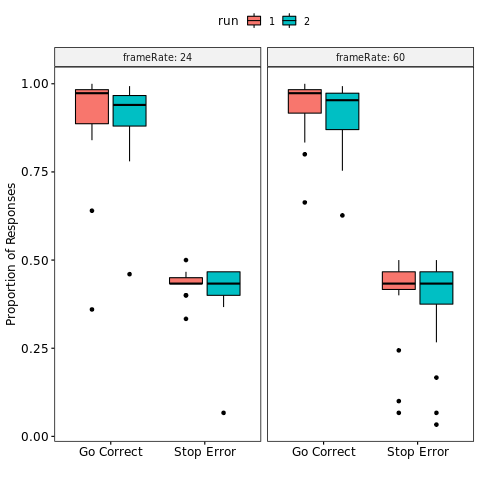

In [12]:
%%R
names(SST_prop)[names(SST_prop) == 'value'] <- 'prop'

SST_prop %>%
  group_by(condition, run) %>%
  ggboxplot(., "condition", "prop", fill = "run", ylab = "Proportion of Responses", xlab = "", facet.by = "frameRate", short.panel.labs = FALSE) + 
    scale_x_discrete(labels = c('Go Correct','Stop Error', 'SSD')) 

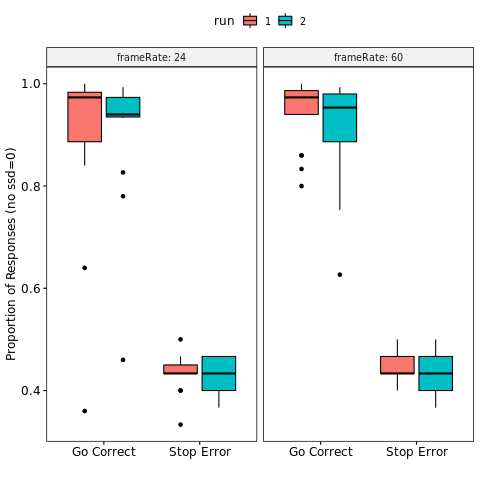

In [80]:
%%R
# filter out SSD = 0 
names(SST_prop_filt)[names(SST_prop_filt) == 'value'] <- 'prop'

SST_prop_filt %>%
  group_by(condition, run) %>%
  ggboxplot(., "condition", "prop", fill = "run", ylab = "Proportion of Responses (no ssd=0)", xlab = "", facet.by = "frameRate", short.panel.labs = FALSE) + 
    scale_x_discrete(labels = c('Go Correct','Stop Error', 'SSD')) 

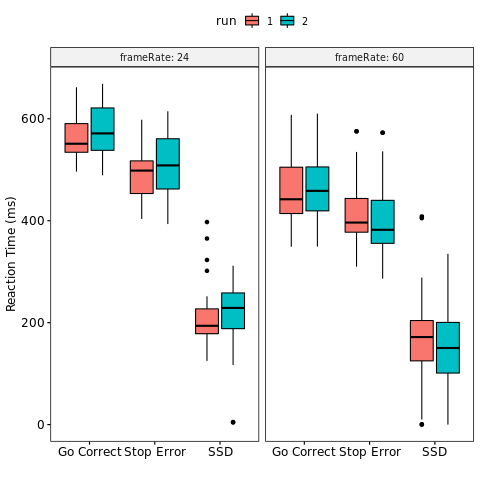

In [73]:
%%R
names(SST_rt)[names(SST_rt) == 'value'] <- 'RT'

SST_rt %>%
  group_by(condition, run) %>%
  ggboxplot(., "condition", "RT", fill = "run", ylab = "Reaction Time (ms)", xlab = "", facet.by = "frameRate", short.panel.labs = FALSE) + 
    scale_x_discrete(labels = c('Go Correct','Stop Error', 'SSD')) 

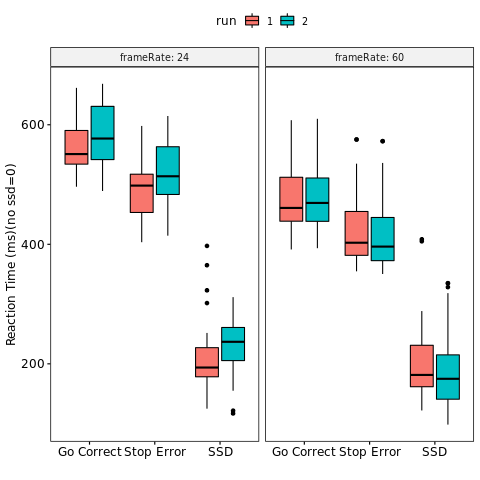

In [81]:
%%R
# filter out SSD = 0 

SST_rt_filt %>%
  group_by(condition, run) %>%
  ggboxplot(., "condition", "value", fill = "run", ylab = "Reaction Time (ms)(no ssd=0)", xlab = "", facet.by = "frameRate", short.panel.labs = FALSE) + 
    scale_x_discrete(labels = c('Go Correct','Stop Error', 'SSD')) 

# calculate SSRT
- method 1: median corr_go_rt minus mean SSD
- method 2: Go RT at the percentile corresponding to the proportion of unsuccessfully inhibited stop trials and subtracting the mean stop-signal delay

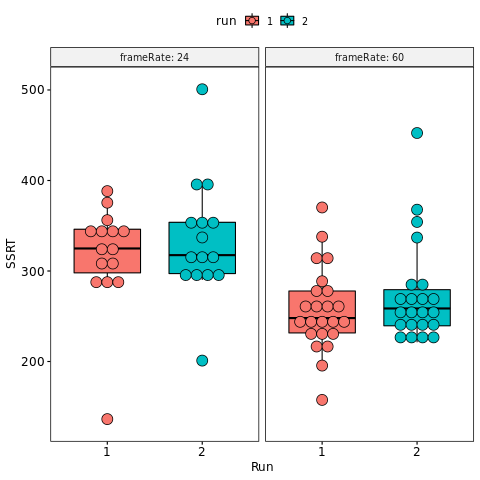

In [50]:
%%R

median_go_rt <- SST_long %>%
  filter(trial_type == 'go' & key_response.corr == 1) %>%
  group_by(participant, run, frameRate) %>%
  summarise(median = median(key_response.rt)) 

SST_long_stop_correct <- SST_long %>%
  filter(trial_type == 'stop' & key_response.corr == 1)

meanSSD <- SST_long_stop_correct %>% group_by(participant, run, frameRate) %>%
  summarise(meanSSD = mean(ss_delay)) 

SSRT <- merge(meanSSD, median_go_rt, by = c('participant','run', 'frameRate'))


mutate(SSRT, SSRT = 1000*(median - meanSSD)) %>%
  ggboxplot(., "run", "SSRT", fill = "run", ylab = "SSRT", xlab = "Run", facet.by = "frameRate", add = "dotplot", short.panel.labs = FALSE)

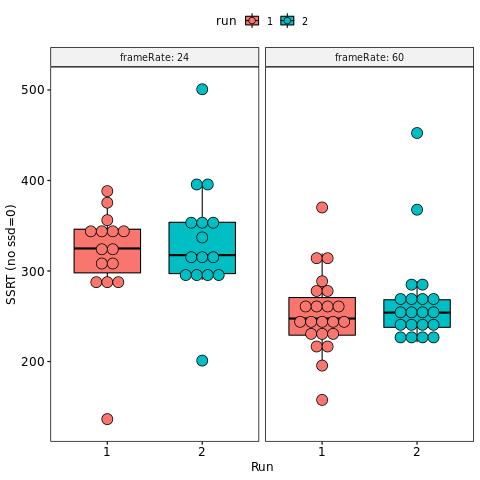

In [82]:
%%R
# filter out SSD = 0 
mutate(filter(SSRT, meanSSD > 0/.09), SSRT = 1000*(median - meanSSD)) %>%
  ggboxplot(., "run", "SSRT", fill = "run", ylab = "SSRT (no ssd=0)", xlab = "Run", facet.by = "frameRate", add = "dotplot", short.panel.labs = FALSE)

In [ ]:
# method 2

SST_long_go_correct <- SST_long %>%
  filter(trial_type == 'go' & key_response.corr == 1) %>%
  group_by(participant, run) %>%
  mutate(rank = rank(key_response.rt), n = n())


SST_long_go_correct %>%
  filter(trial_type == 'go' & key_response.corr == 1) %>%
  select(participant, run, key_response.rt, rank, n) %>%
  arrange(rank) %>%
  group_by(participant, run) %>%

  filter(row_number()==1)

%>% slice(c(1,n()))

key_response.rt where rank = n/2

# calculate number of pts with SSD = 0

In [7]:
%%R
as.data.frame(SST_long %>% group_by(participant, run) %>% filter(ss_delay==0) %>% mutate(occ = n()) %>% filter(row_number()==1) %>% select(participant, run, ss_delay) %>% ungroup())


  trial_type                    arrow_1                   arrow_2 corrAns
1       stop  sst_images/Left_Arrow.bmp sst_images/Stop_Arrow.bmp    none
2       stop  sst_images/Left_Arrow.bmp sst_images/Stop_Arrow.bmp    none
3       stop sst_images/Right_Arrow.bmp sst_images/Stop_Arrow.bmp    none
4       stop  sst_images/Left_Arrow.bmp                      None    None
5       stop sst_images/Right_Arrow.bmp sst_images/Stop_Arrow.bmp    none
6       stop sst_images/Right_Arrow.bmp sst_images/Stop_Arrow.bmp    none
7       stop sst_images/Right_Arrow.bmp sst_images/Stop_Arrow.bmp    none
8       stop  sst_images/Left_Arrow.bmp                      None    None
  jitter run_end_fixation trials.thisRepN trials.thisTrialN trials.thisN
1    802             None               0                36           36
2    704             None               0                 9            9
3   1001             None               0                 7            7
4    822             None               0 

In [38]:
%%R
mutate(SSRT, SSRT = 1000*(median - meanSSD))

   participant run frameRate     meanSSD    median     SSRT
1            1   1        60 0.252941176 0.5365594 283.6182
2            1   2        60 0.278947368 0.5249158 245.9685
3           10   1        60 0.035483871 0.3549621 319.4783
4           10   2        60 0.000000000 0.3542017 354.2017
5           11   1        60 0.208823529 0.4210325 212.2090
6           11   2        60 0.193750000 0.4258386 232.0886
7           12   1        60 0.221875000 0.4881345 266.2595
8           12   2        60 0.173529412 0.4543380 280.8086
9           13   1        60 0.106666667 0.3953105 288.6439
10          13   2        60 0.004000000 0.3717412 367.7412
11          14   1        60 0.164705882 0.4044860 239.7801
12          14   2        60 0.159375000 0.4191179 259.7429
13          16   1        60 0.247058824 0.4950293 247.9705
14          16   2        60 0.247222222 0.5362979 289.0756
15          17   1        60 0.294444444 0.6032643 308.8199
16          17   2        60 0.331578947

In [27]:
%%R

# SST_long %>% group_by(participant, run) %>% filter(ss_delay==0) %>% mutate(occ = n()) %>% filter(row_number()==1) %>% select(participant, run, ss_delay)

zero_ssd <- merge(mutate(SSRT, SSRT = 1000*(median - meanSSD)), as.data.frame(SST_long %>% group_by(participant, run) %>% filter(ss_delay==0) %>% mutate(occ = n()) %>% filter(row_number()==1) %>% select(participant, run) %>% ungroup())
, by = c('participant', 'run'))
zero_ssd

  participant run frameRate     meanSSD    median     SSRT
1          10   1        60 0.035483871 0.3549621 319.4783
2          10   2        60 0.000000000 0.3542017 354.2017
3          13   2        60 0.004000000 0.3717412 367.7412
4           2   2        60 0.003571429 0.4560160 452.4446
5          20   1        60 0.007407407 0.3776012 370.1938
6          22   1        60 0.000000000 0.3378998 337.8998
7          22   2        60 0.000000000 0.3369548 336.9548
8          38   2        24 0.003571429 0.5043451 500.7737


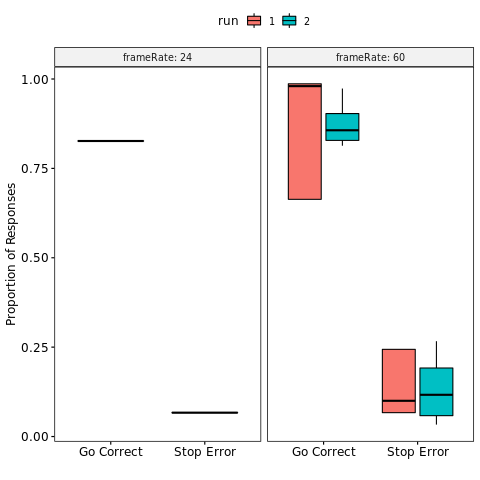

In [33]:
%%R
zero_ssd <- merge(select(zero_ssd, c('participant', 'run', 'frameRate')), SST_prop, by = c('participant', 'run', 'frameRate') )
# zero_ssd <- merge(zero_ssd, SST_rt, by = c('participant', 'run', 'frameRate') )
zero_ssd %>% 
    group_by(condition, run) %>%
    ggboxplot(., "condition", "prop", fill = "run", ylab = "Proportion of Responses", xlab = "", facet.by = "frameRate", short.panel.labs = FALSE) + 
    scale_x_discrete(labels = c('Go Correct','Stop Error', 'SSD')) 


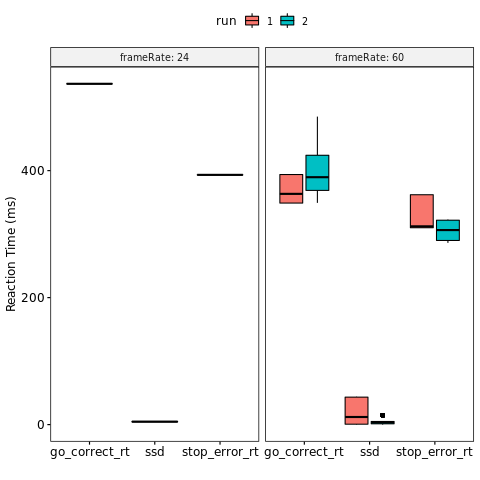

In [41]:
%%R
zero_ssd <- merge(select(zero_ssd, c('participant', 'run', 'frameRate')), SST_rt, by = c('participant', 'run', 'frameRate') )
# zero_ssd <- merge(zero_ssd, SST_rt, by = c('participant', 'run', 'frameRate') )
# zero_ssd
zero_ssd %>% 
    group_by(condition, run) %>%
    ggboxplot(., "condition", "RT", fill = "run", ylab = "Reaction Time (ms)", xlab = "", facet.by = "frameRate", short.panel.labs = FALSE) 
#     + scale_x_discrete(labels = c('Go Correct','Stop Error', 'SSD')) 

# coefficient of variation

/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: `stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

  warnings.warn(x, RRuntimeWarning)


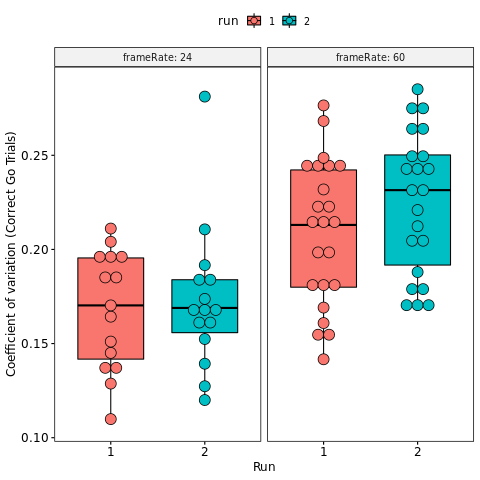

In [23]:
%%R

SST_long %>%
  filter(trial_type != "") %>%
  group_by(participant, run, trial_type, frameRate) %>%
  summarise(sd_rt = sd(key_response.rt, na.rm=TRUE), mean_rt = mean(key_response.rt, na.rm=TRUE)) %>%
  mutate(CoV = sd_rt/mean_rt) %>%
  filter(sd_rt > 0.001) %>%
  ggboxplot(., "trial_type", "CoV", fill = "run", ylab = "Coefficient of variation (all trials)", facet.by = "frameRate", xlab = "Trial Type", add = "dotplot", short.panel.labs = FALSE)

SST_long %>%
  filter(trial_type == 'go' & key_response.corr == 1) %>%
  group_by(participant, run, frameRate) %>%
  summarise(sd_rt = sd(key_response.rt), mean_rt = mean(key_response.rt)) %>%
  mutate(CoV = sd_rt/mean_rt) %>%
   filter(sd_rt > 0.001) %>% 
  ggboxplot(., "run", "CoV", fill = "run", ylab = "Coefficient of variation (Correct Go Trials)", xlab = "Run", facet.by = "frameRate", add = "dotplot", short.panel.labs = FALSE)